# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
l1_lambda=0.1

# 2. Loading data

In [3]:
Training_samples=5400
Validating_samples=600
Testing_samples=4000

(x_train_, y_train_), (x_test_, y_test_) = mnist.load_data()
x_train = x_train_.reshape(60000, 28*28).astype('float32')[0:Training_samples] / 255.
x_validate = x_train_.reshape(60000, 28*28).astype('float32')[Training_samples:Training_samples+Validating_samples] / 255.
x_test__ = x_test_.reshape(10000, 28*28).astype('float32') / 255.

np.random.seed(seed)
x_test__num,_=x_test__.shape
index=np.arange(x_test__num)
np.random.shuffle(index)

x_test=x_test__[index][0:Testing_samples]

y_train=y_train_[0:Training_samples]
y_validate=y_train_[Training_samples:Training_samples+Validating_samples]
y_test=y_test_[index][0:Testing_samples]

y_train_onehot_ = np.array(y_train)
y_validate_onehot_ = np.array(y_validate)
y_test_onehot_ = np.array(y_test)

C_train_x=x_train_.reshape(60000, 28*28).astype('float32')[0:Training_samples+Validating_samples] / 255.
C_train_y=y_train_[0:Training_samples+Validating_samples]
C_test_x=x_test
C_test_y=np.array(y_test)

y_train_onehot = y_train_onehot_#to_categorical(y_train_onehot_)
y_validate_onehot = y_validate_onehot_#to_categorical(y_validate_onehot_)
y_test_onehot = y_test_onehot_#to_categorical(y_test_onehot_)

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_validate: ' + str(x_validate.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train_onehot.shape))
print('Shape of y_validate: ' + str(y_validate_onehot.shape))
print('Shape of y_test: ' + str(y_test_onehot.shape))

print('Shape of C_train_x: ' + str(C_train_x.shape)) 
print('Shape of C_train_y: ' + str(C_train_y.shape)) 
print('Shape of C_test_x: ' + str(C_test_x.shape)) 
print('Shape of C_test_y: ' + str(C_test_y.shape)) 
#F.show_data_figures(x_train_[0:120],28,28,40)

Shape of x_train: (5400, 784)
Shape of x_validate: (600, 784)
Shape of x_test: (4000, 784)
Shape of y_train: (5400,)
Shape of y_validate: (600,)
Shape of y_test: (4000,)
Shape of C_train_x: (6000, 784)
Shape of C_train_y: (6000,)
Shape of C_test_x: (4000, 784)
Shape of C_test_y: (4000,)


# 3. Model

In [4]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, l1_lambda, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.l1_lambda=l1_lambda

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0.999999, maxval=0.9999999, seed=seed),
                                      trainable=True,
                                      regularizer=regularizers.l1(self.l1_lambda),
                                      constraint=constraints.NonNeg())
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=36):
        kernel=self.kernel        
        if selection:
            kernel_=K.transpose(kernel)
            print(kernel_.shape)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Autoencoder(p_data_feature=x_train.shape[1],\
                p_encoding_dim=36,\
                p_learning_rate= 1E-3):
    input_img = Input(shape=(p_data_feature,), name='input_img')

    encoded = Dense(p_encoding_dim, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(input_img)
    bottleneck=encoded
    decoded = Dense(p_data_feature, activation='linear',kernel_initializer=initializers.glorot_uniform(seed))(encoded)

    latent_encoder = Model(input_img, bottleneck)
    autoencoder = Model(input_img, decoded)
    
    autoencoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    #print('Latent Encoder Structure-------------------------------------')
    #latent_encoder.summary()
    return autoencoder,latent_encoder

#--------------------------------------------------------------------------------------------------------------------------------
def Identity_Autoencoder(p_data_feature=x_train.shape[1],\
                         p_encoding_dim=50,\
                         p_learning_rate= 1E-3,\
                         p_l1_lambda=0.1):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             l1_lambda=p_l1_lambda,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    
    bottleneck_score=encoded_score
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)

    latent_encoder_score = Model(input_img, bottleneck_score)
    autoencoder = Model(input_img, decoded_score)
    
    autoencoder.compile(loss='mean_squared_error',\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,latent_encoder_score

# 4. Running

In [5]:
epochs_number=1000
batch_size_value=256

---
### 4.1.1 Identity Autoencoder
---





Autoencoder Structure-------------------------------------
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye (None, 784)               0         
_________________________________________________________________
feature_selection (Feature_S (None, 784)               784       
_________________________________________________________________
autoencoder_hidden_layer (De (None, 50)                39250     
_________________________________________________________________
autoencoder_output (Dense)   (None, 784)               39984     
Total params: 80,018
Trainable params: 80,018
Non-trainable params: 0
_________________________________________________________________


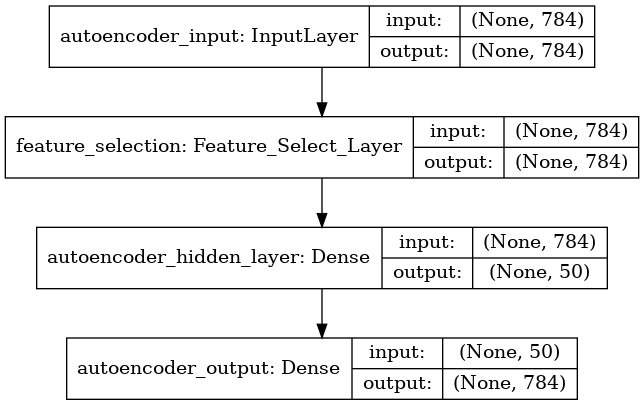

In [6]:
Ide_AE,\
latent_encoder_score_Ide_AE=Identity_Autoencoder(p_data_feature=x_train.shape[1],\
                                                 p_encoding_dim=50,\
                                                 p_learning_rate= 1E-3,\
                                                 p_l1_lambda=l1_lambda)

file_name="./log/ide_ae.png"
plot_model(Ide_AE, to_file=file_name,show_shapes=True)

In [7]:
model_checkpoint=ModelCheckpoint('./log_weights/Ide_AE_weights.MNIST{epoch:04d}.hdf5',period=100,save_weights_only=True,verbose=1)
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(Ide_AE.layers[1].get_weights()))

Ide_AE_history = Ide_AE.fit(x_train, x_train,\
                            epochs=epochs_number,\
                            batch_size=batch_size_value,\
                            shuffle=True,\
                            verbose=0,\
                            validation_data=(x_validate,x_validate),\
                            callbacks=[model_checkpoint])




Epoch 00100: saving model to ./log_weights/Ide_AE_weights.MNIST0100.hdf5

Epoch 00200: saving model to ./log_weights/Ide_AE_weights.MNIST0200.hdf5

Epoch 00300: saving model to ./log_weights/Ide_AE_weights.MNIST0300.hdf5

Epoch 00400: saving model to ./log_weights/Ide_AE_weights.MNIST0400.hdf5

Epoch 00500: saving model to ./log_weights/Ide_AE_weights.MNIST0500.hdf5

Epoch 00600: saving model to ./log_weights/Ide_AE_weights.MNIST0600.hdf5

Epoch 00700: saving model to ./log_weights/Ide_AE_weights.MNIST0700.hdf5

Epoch 00800: saving model to ./log_weights/Ide_AE_weights.MNIST0800.hdf5

Epoch 00900: saving model to ./log_weights/Ide_AE_weights.MNIST0900.hdf5

Epoch 01000: saving model to ./log_weights/Ide_AE_weights.MNIST1000.hdf5


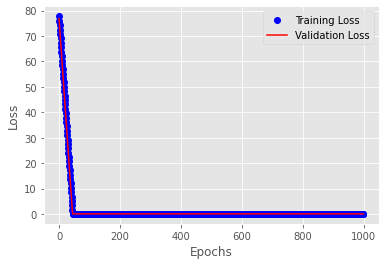

In [8]:
loss = Ide_AE_history.history['loss']
val_loss = Ide_AE_history.history['val_loss']

epochs = range(epochs_number)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
p_data=Ide_AE.predict(x_test)
numbers=x_test.shape[0]*x_test.shape[1]

print("MSE for one-to-one map layer",np.sum(np.power(np.array(p_data)-x_test,2))/numbers)

MSE for one-to-one map layer 0.06767406728316326


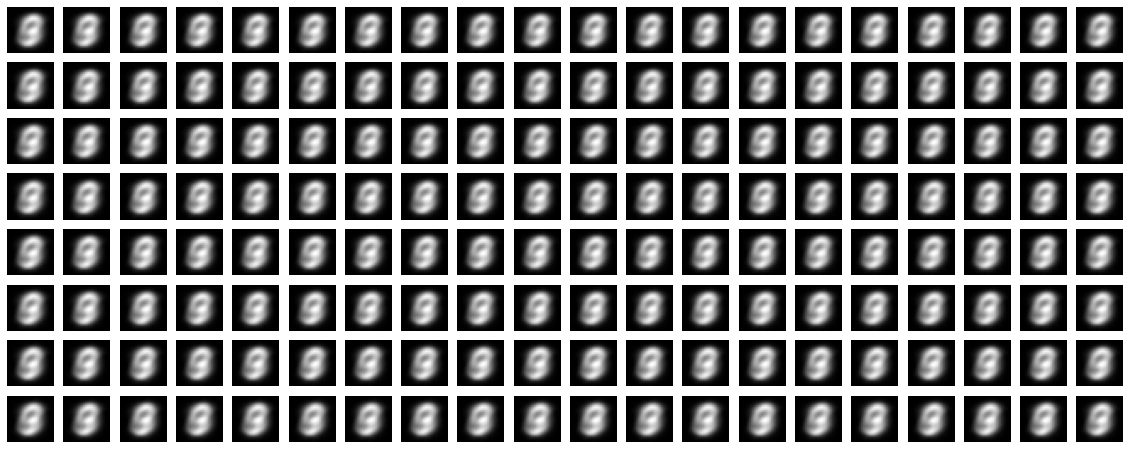

In [10]:
# Reconsctructed result
F.show_data_figures(p_data[0:160],w=28,h=28,columns = 20)

---
key_number=50
---

In [11]:
key_number=50

In [12]:
key_features=F.top_k_keepWeights_1(Ide_AE.get_layer(index=1).get_weights()[0],key_number)

selected_position_list=np.where(key_features>0)[0]

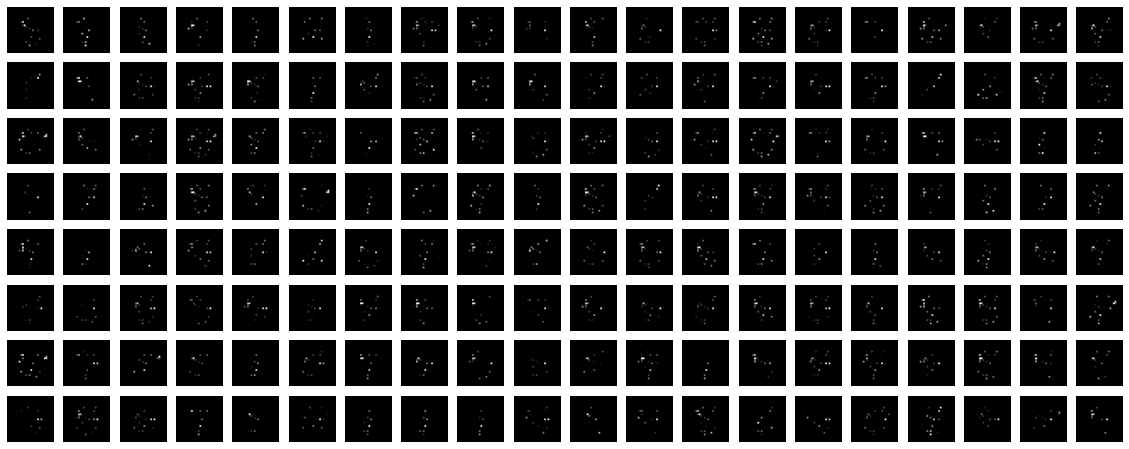

In [13]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST0200.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

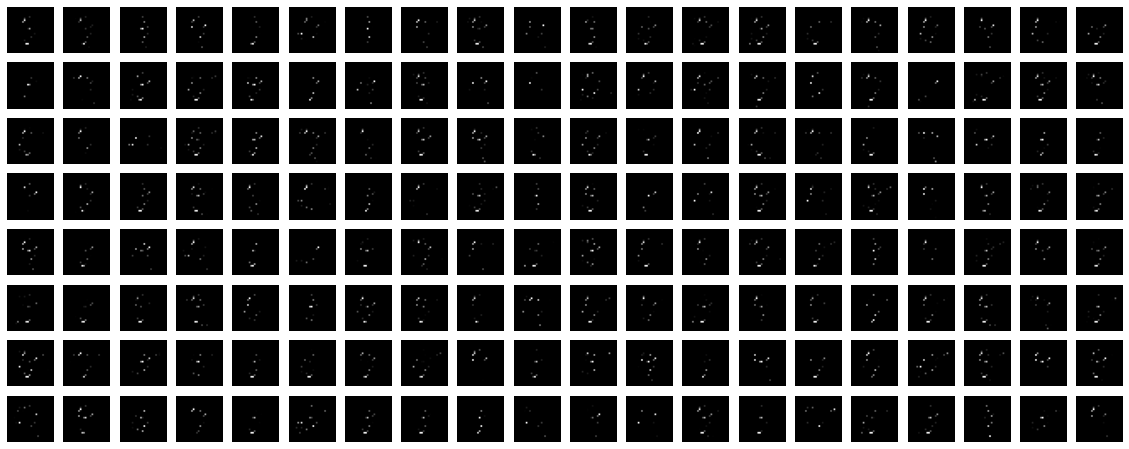

In [14]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST0400.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

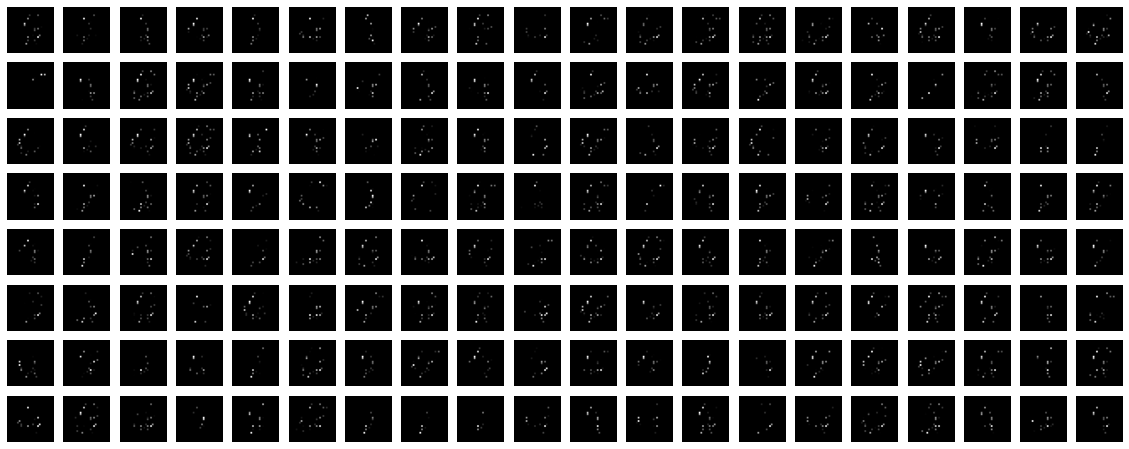

In [15]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST0600.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

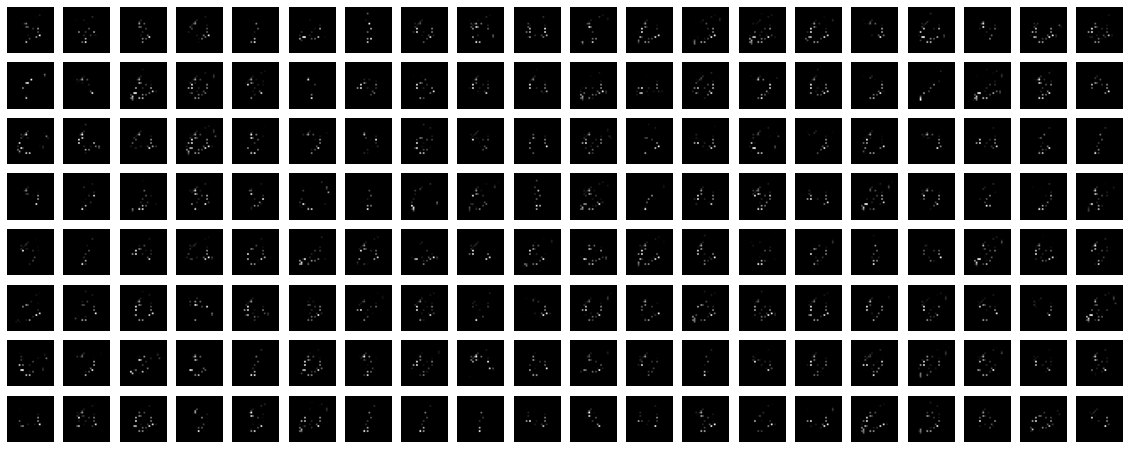

In [16]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST0800.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

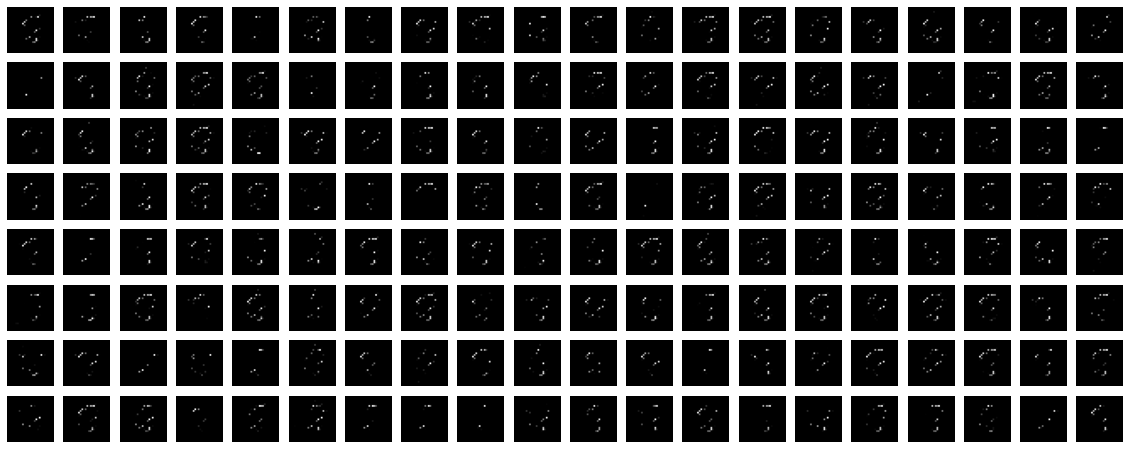

In [17]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST1000.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

In [18]:
np.sum(Ide_AE.get_layer(index=1).get_weights()[0]>0)

34

# Original samples

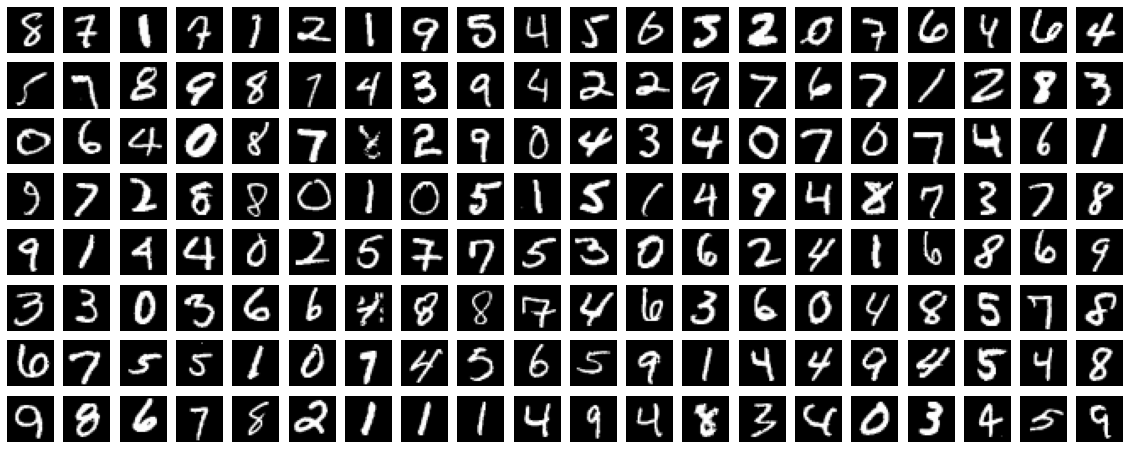

In [19]:
F.show_data_figures(x_test[0:160],w=28,h=28,columns = 20)

# 5 Classifying

In [20]:
train_feature=C_train_x
train_label=C_train_y
test_feature=C_test_x
test_label=C_test_y
p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)

Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.943
Testing accuracy： 0.943


In [21]:
train_feature_=np.multiply(C_train_x, key_features)
train_feature=F.compress_zero_withkeystructure_list(train_feature_,selected_position_list)
print(train_feature.shape)
train_label=C_train_y

test_feature_=np.multiply(C_test_x, key_features)
test_feature=F.compress_zero_withkeystructure_list(test_feature_,selected_position_list)
print(test_feature.shape)
test_label=C_test_y

p_seed=seed
F.ETree(train_feature,train_label,test_feature,test_label,p_seed)
print("\n\n")

(6000, 34)
(4000, 34)
Training accuracy： 1.0
Training accuracy： 1.0
Testing accuracy： 0.81775
Testing accuracy： 0.81775





# 6. Selected features reconstruction

In [22]:
x_test_selected_list=[]
for x_test_i in x_test[0:160]:
    x_test_selected_list.append(x_test_i*key_features)

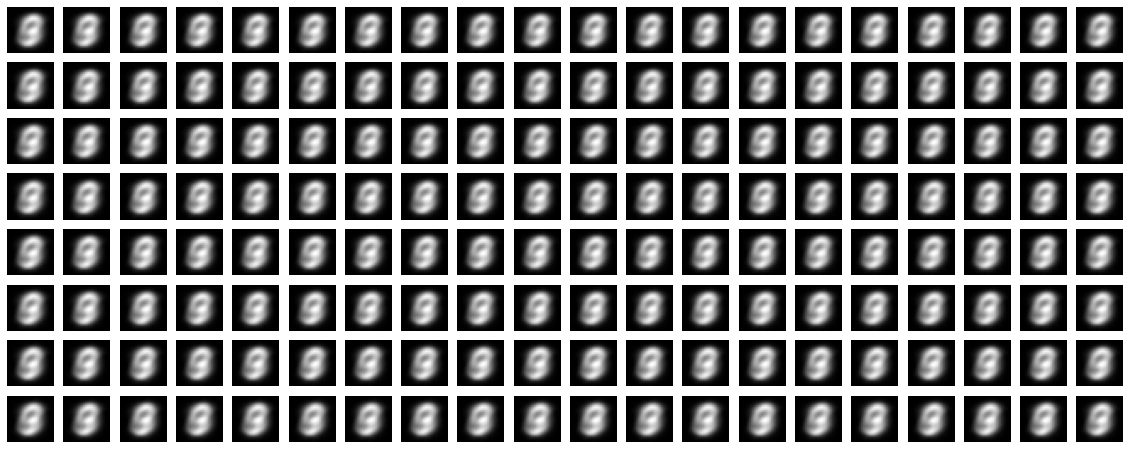

In [23]:
x_test_selected=np.array(x_test_selected_list)
p_data=Ide_AE.predict(x_test_selected)
F.show_data_figures(p_data,w=28,h=28,columns = 20)

# 7. Merge features

In [24]:
key_features_points=key_features.reshape((28, 28))

In [25]:
key_feature_catch_index=[]
for x_test_i in x_test[0:160]:
    key_feature_catch_i=x_test_i.reshape(28,28)*key_features_points    
    key_feature_catch_i_nonzeros_index=np.where(key_feature_catch_i>0)
    key_feature_catch_i_nonzeros_index_pair=[]
    for i in np.arange(len(key_feature_catch_i_nonzeros_index[0])):
        key_feature_catch_i_nonzeros_index_pair.append([key_feature_catch_i_nonzeros_index[0][i],key_feature_catch_i_nonzeros_index[1][i]])
    key_feature_catch_index.append(key_feature_catch_i_nonzeros_index_pair)

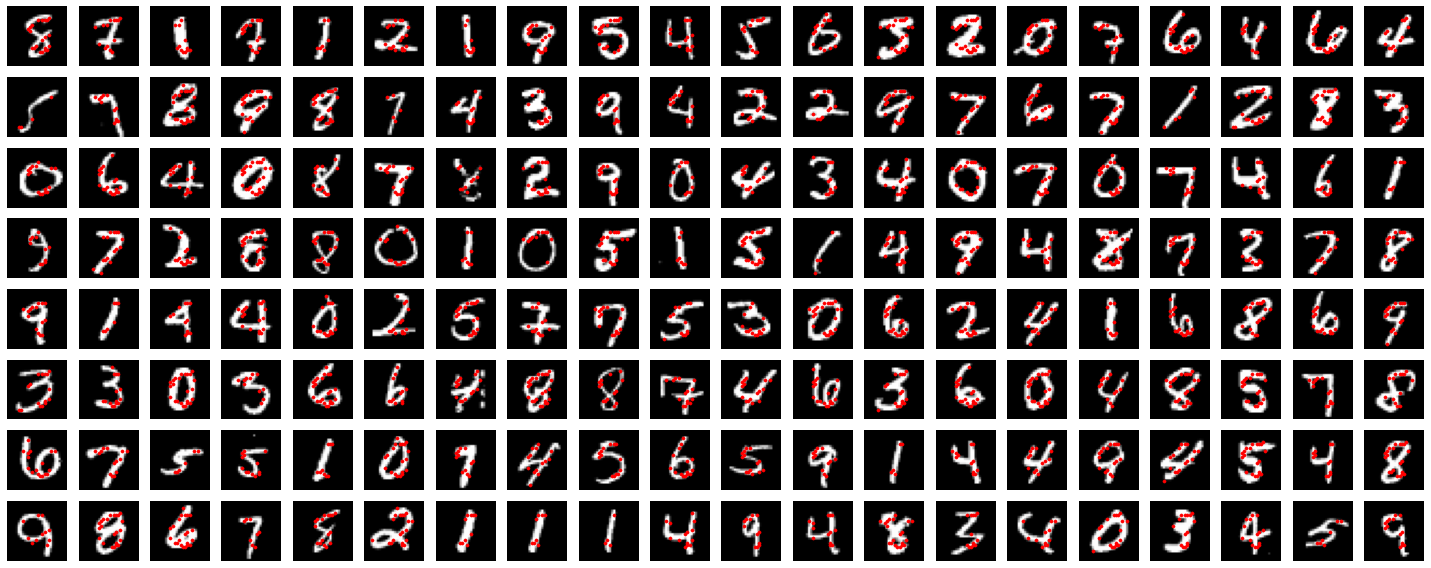

In [26]:
F.show_data_figures_with_hierarchy_keyfeature(x_test[0:160],key_feature_catch_index,w=28,h=28,columns = 20)

# 8. Reconstruction loss

In [27]:
from sklearn.linear_model import LinearRegression

def mse_check(train, test):
    LR = LinearRegression(n_jobs = -1)
    LR.fit(train[0], train[1])
    MSELR = ((LR.predict(test[0]) - test[1]) ** 2).mean()
    return MSELR

In [28]:
train_feature_=np.multiply(C_train_x, key_features)
C_train_selected_x=F.compress_zero_withkeystructure(train_feature_,selected_position_list)
print(C_train_selected_x.shape)

test_feature_=np.multiply(C_test_x, key_features)
C_test_selected_x=F.compress_zero_withkeystructure(test_feature_,selected_position_list)
print(C_test_selected_x.shape)


train_feature_tuple=(C_train_selected_x,C_train_x)
test_feature_tuple=(C_test_selected_x,C_test_x)

reconstruction_loss=mse_check(train_feature_tuple, test_feature_tuple)
print(reconstruction_loss)

IndexError: index 99 is out of bounds for axis 0 with size 28

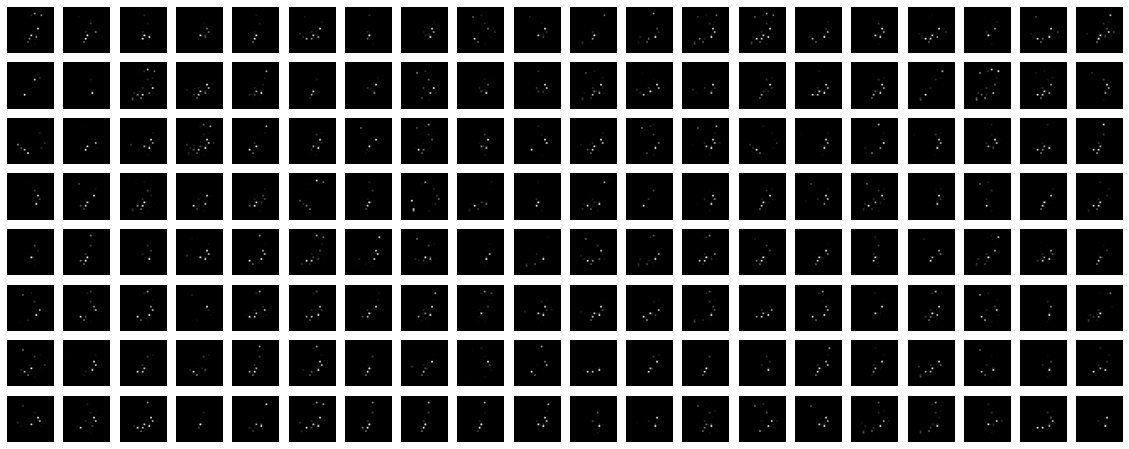

In [29]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST0100.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

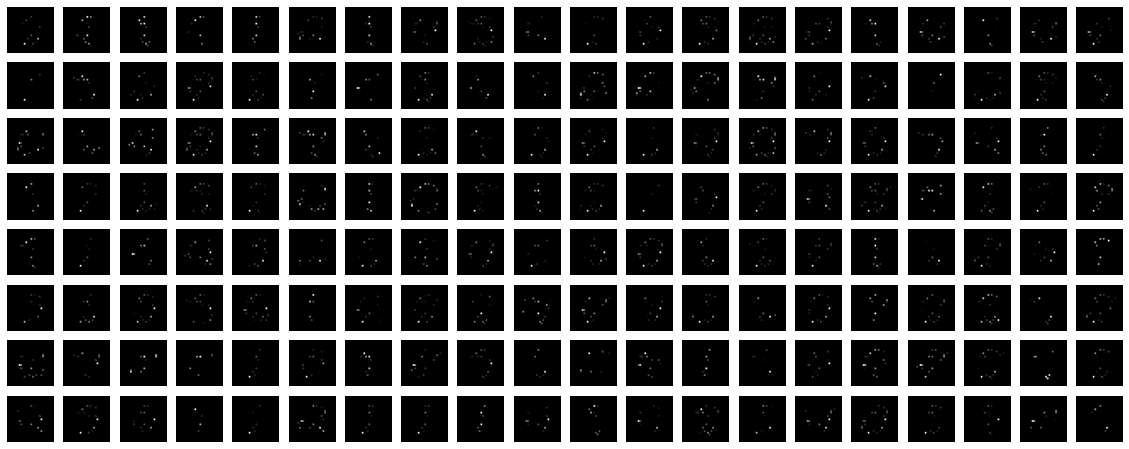

In [30]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST0500.hdf5',x_test,p_sample_number=160,p_key_number=key_number)

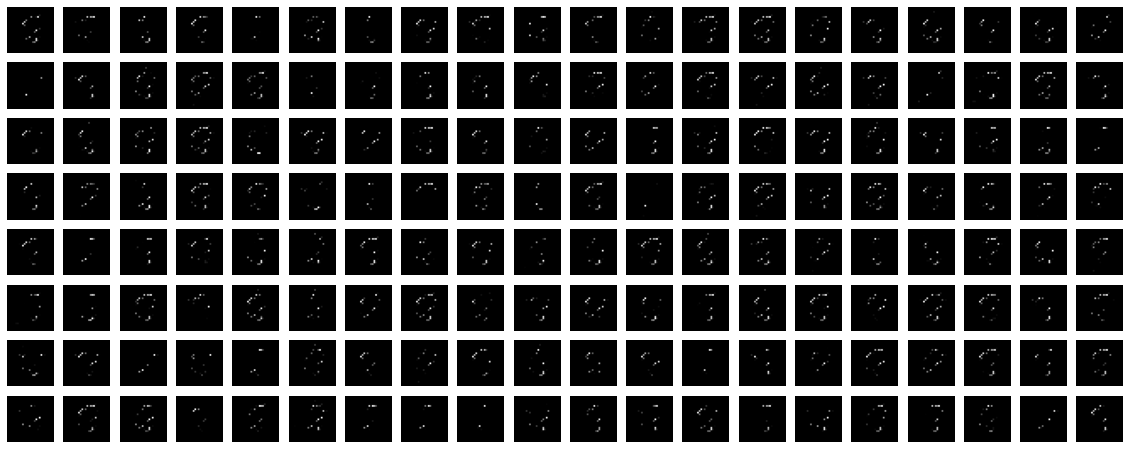

In [31]:
F.show_feature_selection('./log_weights/Ide_AE_weights.MNIST1000.hdf5',x_test,p_sample_number=160,p_key_number=key_number)